# Part 2: Multi-tissue characterization of eSTRs

In [13]:
# Set up
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest

############ Set up paths #############
SAVEPLOT = True
MIN_CAUSAL_SCORE = 0.3 # Top 5%
GENEANNOT = "/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv"

# Load mashR results
betas = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "posterior_betas.tsv"), sep="\t", index_col=0)
beta_ses = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "posterior_beta_ses.tsv"), sep="\t", index_col=0)
zscores = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "zscores.tsv"), sep="\t", index_col=0)
ntissues = len(betas.columns)

# Load eSTRs
estrs = pd.read_csv(os.path.join(RESULTSDIR, "SuppTable_CAVIAR.tsv"), sep="\t")
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot["gene.id"].apply(lambda x: x.split(".")[0])
estrs = pd.merge(estrs, geneannot[["gene", "gene.strand","gene.start","gene.stop"]], on=["gene"])
estrs["motif"] = estrs.apply(lambda x: x["str.motif.forward"] if x["gene.strand"]=="+" else x["str.motif.reverse"], 1)
estrs["dist.tss"] = estrs.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="+" else (x["gene.stop"]-x["str.start"]), 1)

causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

ZTHRESH = 3

Populating the interactive namespace from numpy and matplotlib


In [6]:
# Load master tables
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
}
TISSUES = list(COLORS.keys())

# Master tables
master = {} # Map of tissue -> data
for t in TISSUES:
    d = pd.read_csv(os.path.join(DATADIR, "mastertables", "%s_master.tab"%t), sep="\t", 
                            usecols=["chrom","gene","gene.name","str.start","linreg.beta","linreg.pval", 
                                     "linreg.significant",
                                     "anova.pval","caviar.str.score","caviar.str.rank","mashr.significant"])
    d["gene"] = d["gene"].apply(lambda x: x.split(".")[0])
    d["signif_%s"%t] = d["linreg.significant"]
    master[t] =  d 

In [14]:
CAUSAL_COLOR = "black"
ESTR_COLOR = "gray"

def NormTable(t, total):
    x = t[0][0]+t[0][1]+t[1][0]
    t[1][1] = total-x
    return t

def GetEnrichments(ref, estrs, causal, annotations, annot_col=True):
    """
    Return data frame with estr and causal enrichments for all annotations
    if annot_col, use "annot" column. else use annotation os the column itself
    """
    num_total = []
    num_estrs = []
    pval_estrs = []
    odds_estrs = []
    num_causal = []
    pval_causal = []
    odds_causal = []
    
    dir_estrs = []
    pval_dir_estrs = []
    dir_causal = []
    pval_dir_causal = []
    
    estrs_annot = estrs.groupby(["chrom","str.start"], as_index=False).agg({"beta": maxabs})
    causal_annot = causal.groupby(["chrom","str.start"], as_index=False).agg({"beta": maxabs})

    estrs_annot = pd.merge(estrs_annot[["chrom","str.start","beta"]].drop_duplicates(), ref, on=["chrom","str.start"])
    causal_annot = pd.merge(causal_annot[["chrom","str.start","beta"]].drop_duplicates(), ref, on=["chrom","str.start"])
    
    num_total_ref = ref.shape[0]
    num_total_estr = estrs_annot.shape[0]
    num_total_causal = causal_annot.shape[0]
    
    for annot in annotations:
        if annot_col:
            num_annot_ref = ref[ref["annot"]==annot].shape[0]
            num_annot_estr = estrs_annot[estrs_annot["annot"]==annot].shape[0]
            num_annot_causal = causal_annot[causal_annot["annot"]==annot].shape[0]
        else:
            num_annot_ref = ref[ref[annot]>0].shape[0]
            num_annot_estr = estrs_annot[estrs_annot[annot]>0].shape[0]
            num_annot_causal = causal_annot[causal_annot[annot]>0].shape[0]
        # Test estrs
        t_estr = NormTable([[num_annot_estr, num_total_estr-num_annot_estr], [num_annot_ref-num_annot_estr, 0]], num_total_ref)
        o_estr, p_estr = scipy.stats.fisher_exact(t_estr)
        # Test causal
        t_causal = NormTable([[num_annot_causal, num_total_causal-num_annot_causal], [num_annot_ref-num_annot_causal, 0]], num_total_ref)
        o_causal, p_causal = scipy.stats.fisher_exact(t_causal)
        # Direction
        if annot_col:
            num_pos_estr = sum(estrs_annot[estrs_annot["annot"]==annot]["beta"]>0)
            num_pos_causal = sum(causal_annot[causal_annot["annot"]==annot]["beta"]>0)
        else:
            num_pos_estr = sum(estrs_annot[estrs_annot[annot]>0]["beta"]>0)
            num_pos_causal = sum(causal_annot[causal_annot[annot]>0]["beta"]>0)
        dir_estrs.append(num_pos_estr*1.0/num_annot_estr)
        dir_causal.append(num_pos_causal*1.0/num_annot_causal)                            
        pval_dir_estrs.append(scipy.stats.binom_test(num_pos_estr, num_annot_estr))
        pval_dir_causal.append(scipy.stats.binom_test(num_pos_causal, num_annot_causal))
        # Add to data
        num_total.append(num_annot_ref)
        num_estrs.append(num_annot_estr)
        num_causal.append(num_annot_causal)
        odds_estrs.append(o_estr)
        pval_estrs.append(p_estr)
        odds_causal.append(o_causal)
        pval_causal.append(p_causal)
        
    annotenrich = pd.DataFrame({
        "annot": annotations,
        "num.total": num_total,
        "num.estrs": num_estrs,
        "num.causal": num_causal,
        "pval.estrs": pval_estrs,
        "odds.estrs": odds_estrs,
        "pval.causal": pval_causal,
        "odds.causal": odds_causal,
        "dir.estrs": dir_estrs,
        "p.dir.estrs": pval_dir_estrs,
        "dir.causal": dir_causal,
        "p.dir.causal": pval_dir_causal
    })
    return annotenrich

def maxabs(x):
    abs_x = [abs(item) for item in x]
    return list(x)[abs_x.index(max(abs_x))]

def OutputEnrichmentTable(enrich, fname):
    cols = ["annot","num.total","num.estrs","num.causal"] + \
        ["pval.estrs","odds.estrs", "pval.causal","odds.causal"]
    enrich.sort_values("odds.causal", ascending=False)[cols].to_csv(fname, index=False)

def PlotEnrich(enrich, size=None, fname=None, title=None, ax=None, log2=True):
    #enrich = enrich.sort_values("odds.causal")
    w = 0.4
    if ax is None:
        fig = plt.figure()
        if size is not None: fig.set_size_inches(size)
        ax = fig.add_subplot(111)
    if log2: ax.barh(range(enrich.shape[0]), np.log2(enrich["odds.causal"]), color=CAUSAL_COLOR, height=w)
    else: ax.barh(range(enrich.shape[0]), (enrich["odds.causal"]), color=CAUSAL_COLOR, height=w)
    ax.barh([item+w for item in range(enrich.shape[0])], np.log2(enrich["odds.estrs"]), color=ESTR_COLOR, height=w)
    ax.set_xlabel("Log2 OR", size=15)
    ax.set_yticks(range(enrich.shape[0]))
    ax.set_yticklabels([item.replace("_", " ") for item in enrich["annot"]], size=12)
    ax.set_xticklabels(ax.get_xticks(), size=12);
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.axvline(x=0, linestyle="dashed", color="gray")
    if title is not None: ax.set_title(title)
    if fname is not None: fig.savefig(fname)

In [15]:
# Get mashR results for only eSTRs
def FixIndex(val):
    items = val.split("_")
    return "%s_%s_%s"%(items[0].split(".")[0], items[1], items[2])
zscores.index = [FixIndex(item) for item in zscores.index]
betas.index = [FixIndex(item) for item in betas.index]

estrs_ind = causal.apply(lambda x: "%s_%s_%s"%(x["gene"], x["chrom"],x["str.start"]), 1)
zscores_estrs = zscores.loc[estrs_ind]
betas_estrs = betas.loc[estrs_ind]

In [16]:
# Get pairwise correlation

# Correlation of effect sizes
corrMatrix = np.full((ntissues, ntissues), np.nan)

for tissue1 in TISSUES:
    for tissue2 in TISSUES:
        t1ind = TISSUES.index(tissue1)
        t2ind = TISSUES.index(tissue2)
        eff1 = betas_estrs[tissue1]
        eff2 = betas_estrs[tissue2]
        corrMatrix[t1ind, t2ind] = scipy.stats.spearmanr(eff1, eff2)[0]
        corrMatrix[t2ind, t1ind] = corrMatrix[t1ind, t2ind]

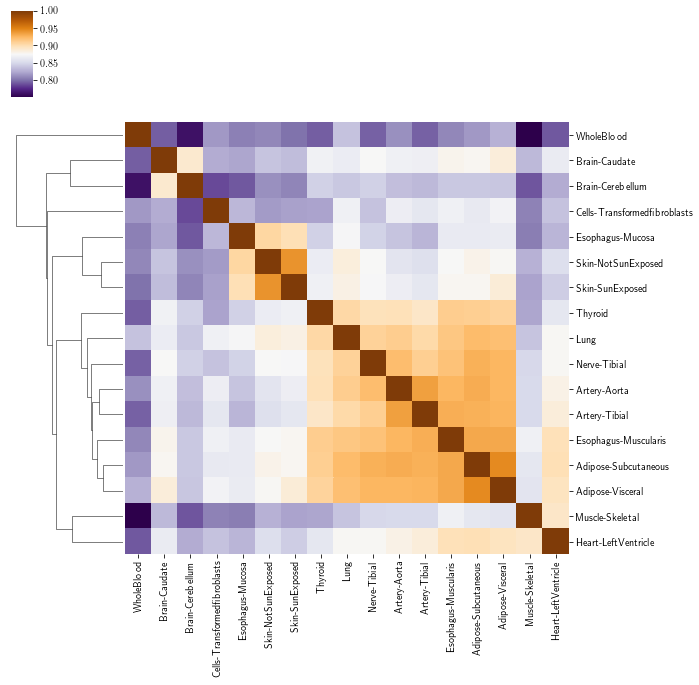

In [17]:
corrMatrix = pd.DataFrame(corrMatrix, columns=TISSUES, index=TISSUES)
cg = sns.clustermap(corrMatrix, cmap="PuOr_r")
cg.ax_col_dendrogram.set_visible(False)
if SAVEPLOT: cg.savefig(os.path.join(RESULTSDIR, "Figure1_mashRHeatmap.pdf"))

shared across 2 or more tissues: 0.8770764119601329
shared across 10 or more tissues: 0.49169435215946844


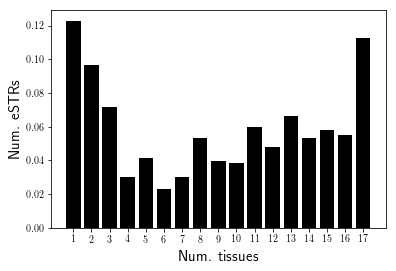

In [20]:
# Tissue sharing
ZTHRESH = 4 # TODO is this a good threshold? check mashr paper
numshared = zscores_estrs.apply(lambda x: sum(abs(x)>=ZTHRESH), 1) # takes a long time to run

# Tissue sharing
zscores_sig = zscores_estrs.copy()
zscores_sig["num"] = numshared
zscores_sig = zscores_sig[zscores_sig["num"]>0]
signum = zscores_sig.groupby("num", as_index=False).agg({"WholeBlood":len})
signum.columns = ["num.tissues", "num.estrs"]
signum["perc.estrs"] = signum["num.estrs"]/sum(signum["num.estrs"])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(signum["num.tissues"], signum["perc.estrs"], color="black");
ax.set_xticks(range(1, ntissues+1));
ax.set_xlabel("Num. tissues", size=15)
ax.set_ylabel("Num. eSTRs", size=15);
    
print("shared across 2 or more tissues: %s"%(sum(signum[signum["num.tissues"]>=2]["perc.estrs"])))
print("shared across 10 or more tissues: %s"%(sum(signum[signum["num.tissues"]>=10]["perc.estrs"])))
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_TissueSharing.pdf"))